<a href="https://colab.research.google.com/github/quvyshnav/Data-Analysis/blob/main/A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets --upgrade --quiet

In [ ]:
 import opendatasets as od

dwnld_url = 'https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing'
od.download(dwnld_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: quvyshnav
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing


In [ ]:
data = './marketing-ab-testing/marketing_AB.csv'

In [ ]:
# Data
import pandas as pd
import numpy as np
from itertools import combinations
import random

# A/B testing
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import logit
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

# Suppress specific warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%config InlineBackend.figure_format='retina'

# Custom color palette
custom_colors = ['#F6BD60', '#F7EDE2', '#F5CAC3', '#84A59D', '#F28482']

sns.set_theme(context='paper', style='whitegrid', palette=custom_colors, font='sans-serif', font_scale=1, color_codes=True,
              rc={'grid.alpha': 0.5, 'axes.titlesize': 14, 'figure.figsize': (12, 6)})

sns.color_palette(custom_colors)

[(0.9647058823529412, 0.7411764705882353, 0.3764705882352941),
 (0.9686274509803922, 0.9294117647058824, 0.8862745098039215),
 (0.9607843137254902, 0.792156862745098, 0.7647058823529411),
 (0.5176470588235295, 0.6470588235294118, 0.615686274509804),
 (0.9490196078431372, 0.5176470588235295, 0.5098039215686274)]

In [ ]:
df = pd.read_csv(data,index_col=0)

In [ ]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [ ]:
df['converted'] = df['converted'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  int64 
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 31.4+ MB


In [ ]:
df.columns

Index(['user id', 'test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

In [ ]:
df.rename(columns={'test group':'test_group',
                   'converted':'converted',
                   'total ads': 'total_ads',
                   'most ads day': 'most_ads_day',
                   'most ads hour': 'most_ads_hour'},inplace=True)

In [ ]:
df.columns

Index(['user id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [ ]:
df.most_ads_day.unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

In [ ]:
df.most_ads_hour.unique()

array([20, 22, 18, 10, 14, 13, 19, 11, 12, 16, 21,  3, 23,  4,  8,  0,  2,
       15,  1,  6, 17,  7,  9,  5])

In [ ]:
df.test_group.unique()

array(['ad', 'psa'], dtype=object)

In [ ]:
df.isna().sum()

,0
user id,0
test_group,0
converted,0
total_ads,0
most_ads_day,0
most_ads_hour,0


In [ ]:
q1 = df['total_ads'].quantile(0.25)
q3 = df['total_ads'].quantile(0.75)
iqr = q3 - q1

low_lim = q1 - 1.5* iqr
up_lim = q3 + 1.5* iqr

outlier = df[(df['total_ads']<low_lim) | (df['total_ads']>up_lim)]
no_outliers = len(outlier)
tot_records = len(df)
outlier_per = (no_outliers/tot_records)*100
outlier_per

8.851710845586048

In [ ]:
outlier.head()

,user id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14
5,1137664,ad,0,734,Saturday,10


In [ ]:
outlier.describe()

,user id,converted,total_ads,most_ads_hour
count,52057.0000,52057.0000,52057.0000,52057.0000
mean,1316165.2913,0.1485,124.5689,14.4060
std,201728.0658,0.3556,92.9344,4.8326
min,900002.0000,0.0000,62.0000,0.0000
25%,1154971.0000,0.0000,74.0000,11.0000
50%,1323827.0000,0.0000,94.0000,14.0000
75%,1486681.0000,0.0000,136.0000,18.0000
max,1654477.0000,1.0000,2065.0000,23.0000


In [ ]:
df[~df.index.isin(outlier.index)]['total_ads'].describe()

,total_ads
count,536044.0000
mean,15.1340
std,14.0636
min,1.0000
25%,4.0000
50%,11.0000
75%,22.0000
max,61.0000


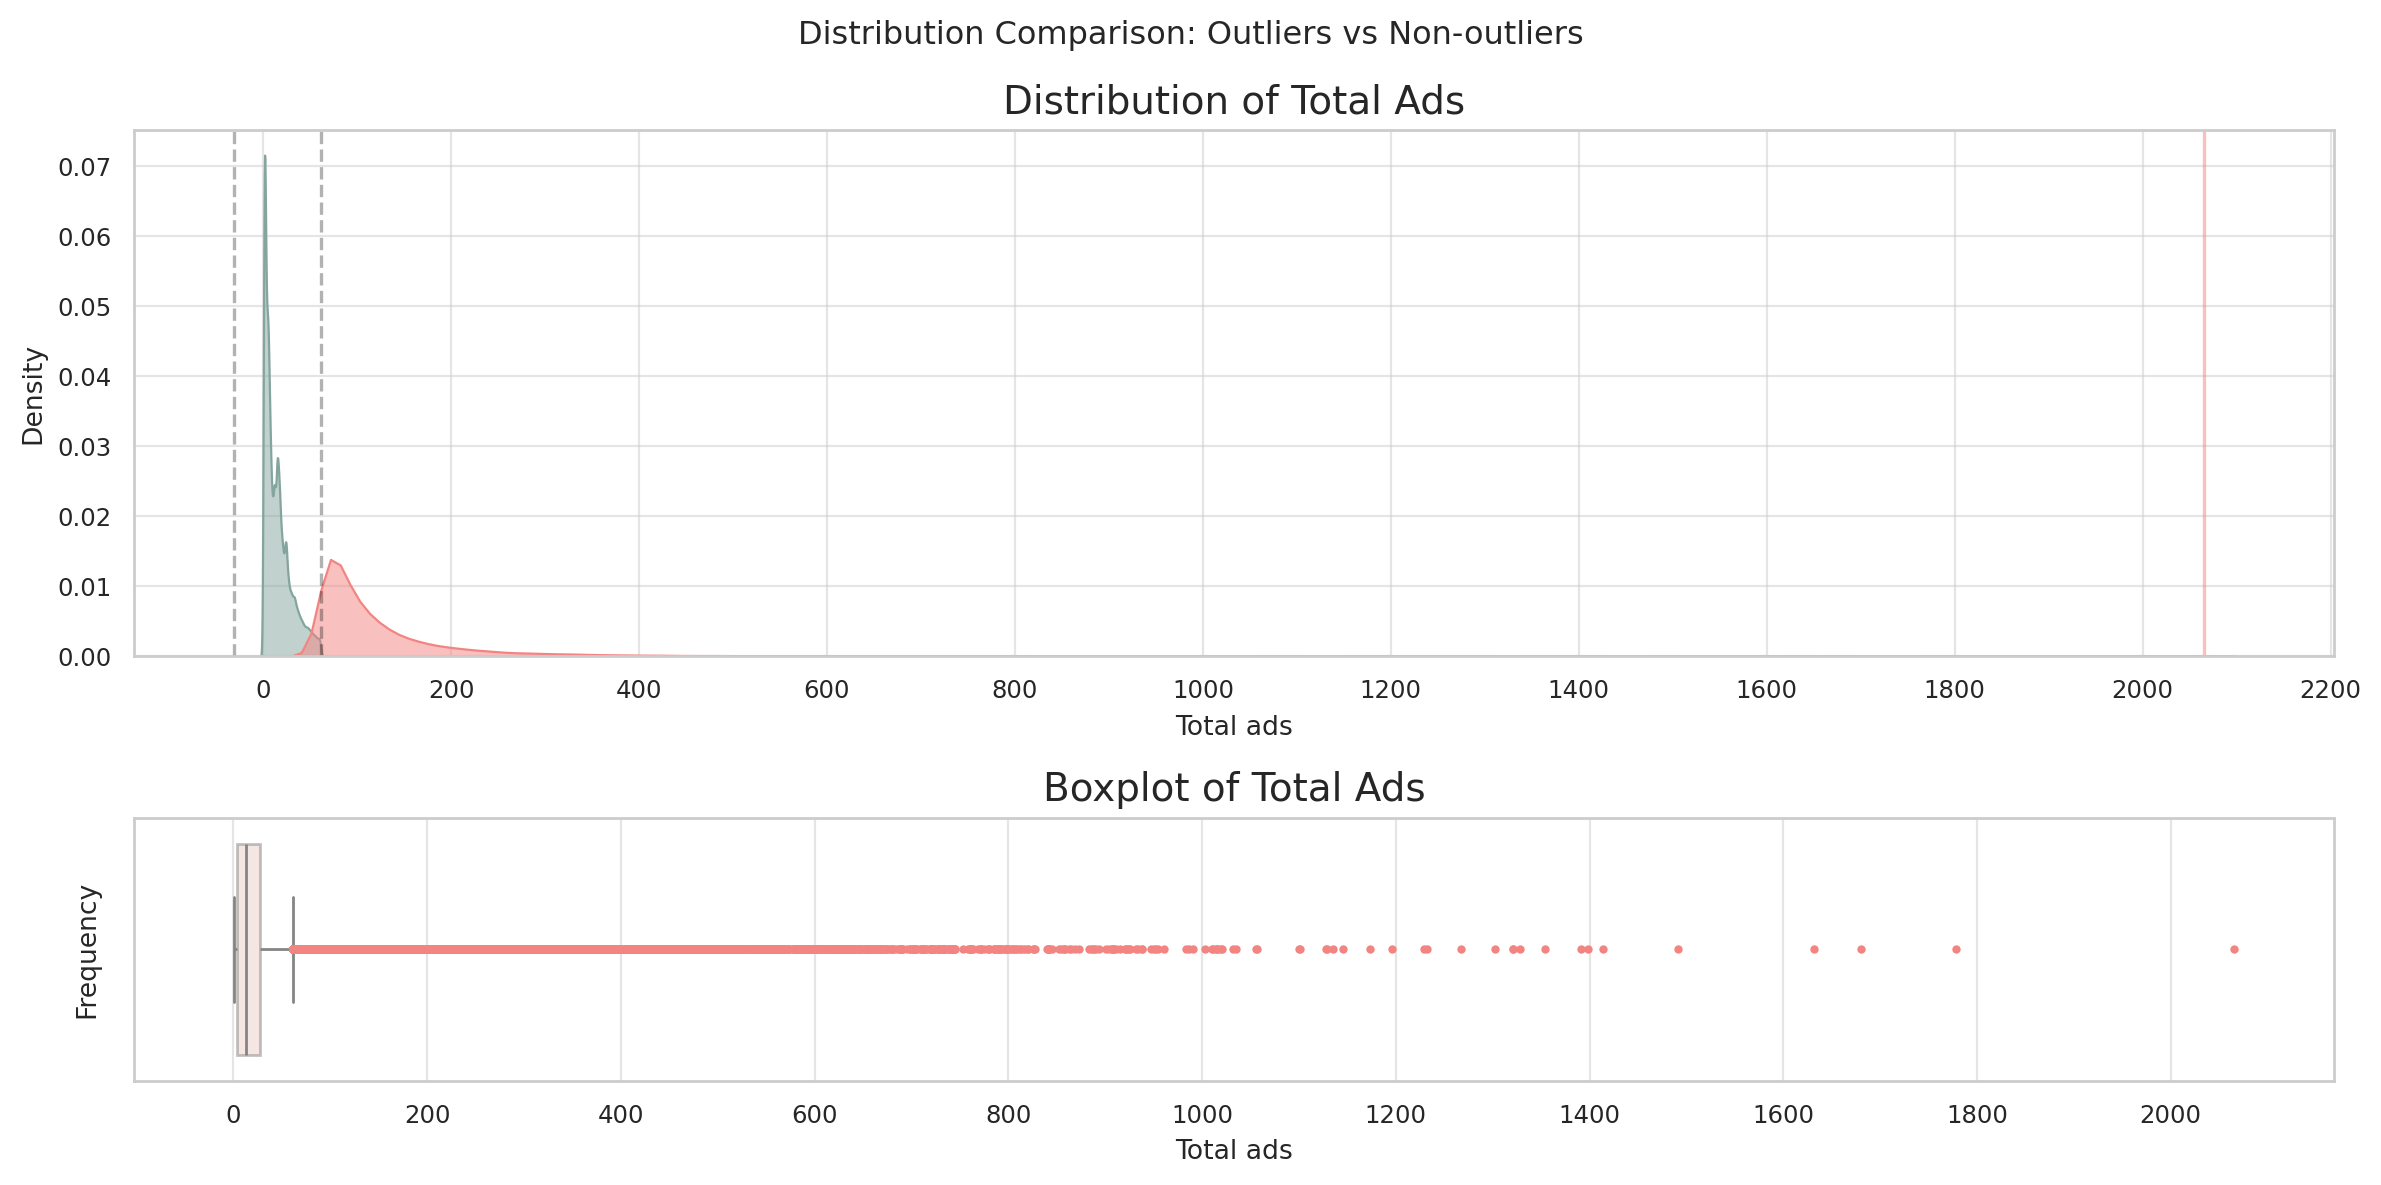

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[2,1])

sns.kdeplot(data=df[~df.index.isin(outlier.index)]['total_ads'],label='Non-Outliers',
            fill=True,alpha=0.5,color=custom_colors[3],ax=ax1)

ax1.set_xlabel('Total ads')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Total Ads')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))

ax1.axvline(x=low_lim, color='black', linestyle='--', alpha=0.3, label='Lower bound')
ax1.axvline(x=up_lim, color='black', linestyle='--', alpha=0.3, label='Upper bound')
ax1.axvline(x=outlier['total_ads'].max(), color=custom_colors[4], linestyle='-', alpha=0.5, label='Max Outlier')

sns.kdeplot(data=outlier['total_ads'],label='Outliers',fill=True,alpha=0.5,
            color=custom_colors[4],ax=ax1)
sns.boxplot(x=df['total_ads'],ax=ax2,color=custom_colors[2],boxprops=dict(alpha=0.5),\
            linewidth=1, flierprops={'marker':'o','markersize':2,'markerfacecolor':custom_colors[4],
                                     'markeredgecolor':custom_colors[4]})

ax2.set_xlabel('Total ads')
ax2.set_ylabel('Frequency')
ax2.set_title('Boxplot of Total Ads')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))

fig.suptitle('Distribution Comparison: Outliers vs Non-outliers')

plt.tight_layout()
plt.show()

In [ ]:
no_outlier = df[~df.index.isin(outlier.index)]

mean_ads = df['total_ads'].mean()
mean_ads_non_out = no_outlier['total_ads'].mean()
std_ads = df['total_ads'].std()
std_ads_non_out = no_outlier['total_ads'].std()

print(f"Mean Ads : {mean_ads:.0f}")
print(f"Mean Ads (Non Outlier) : {mean_ads_non_out:.0f}")
print(f"Std dev Ads : {std_ads:.0f}")
print(f"Std dev Ads (Non Outlier) : {std_ads_non_out:.0f}")

Mean Ads : 25
Mean Ads (Non Outlier) : 15
Std dev Ads : 44
Std dev Ads (Non Outlier) : 14


In [ ]:
conv_rate = (df['converted']==True).mean()*100
print(f"Overall Conversion rate : {conv_rate:.2f}%")
no_out_conversion_rate = (no_outlier['converted']==True).mean()*100
print(f"Conversion rate without outlier : {no_out_conversion_rate:.2f}%")
relative_diff = (conv_rate - no_out_conversion_rate)/conv_rate*100
print(f"Relative difference conversion rate : {relative_diff:.2f}%")

Overall Conversion rate : 2.52%
Conversion rate without outlier : 1.33%
Relative difference conversion rate : 47.41%


In [ ]:
outlier_pivot = outlier.groupby('test_group')['converted'].value_counts(normalize=True).unstack()*100
outlier_pivot

converted,0,1
test_group,,
ad,84.8900,15.1100
psa,91.1658,8.8342


In [ ]:
outlier_conversion = outlier.converted.value_counts(normalize=True).mul(100).round(2).reset_index().iloc[1,1]
print(outlier_conversion)

14.85


In [ ]:
df_clean = df[~(df['total_ads']<low_lim) | (df['total_ads']>up_lim)]
df_clean = df_clean.reset_index(drop=True)
df_clean.head()

,user id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


In [ ]:
# Ztest

treat_group = df_clean[df_clean['test_group']=='ad']
control_group = df_clean[df_clean['test_group']=='psa']

In [ ]:
treat_con = (treat_group['converted']==True).mean()
control_con = (control_group['converted']==True).mean()
diff = treat_con - control_con
rel_lift = diff/control_con*100
print(f"Treatment group conversion rate : {treat_con*100:.2f}%")
print(f"Control group conversion rate : {control_con*100:.2f}%")
print(f'\nAbsolute difference: {diff:.2%}')
print(f'Relative lift: {rel_lift:.2f}%')

Treatment group conversion rate : 2.55%
Control group conversion rate : 1.79%

Absolute difference: 0.77%
Relative lift: 43.09%


In [ ]:
def assum_check(control_group,treat_group,target_col,user_id_col):
  #normality
  n_control = len(control_group)
  p_control = control_group[target_col].mean()
  ctrl_assum = n_control*p_control*(1-p_control)

  n_treat = len(treat_group)
  p_treat = treat_group[target_col].mean()
  treat_assum = n_treat*p_treat*(1-p_treat)

  # Independence
  #1. Within groups duplicates

  duplicate_treat = treat_group[user_id_col].duplicated().sum()
  duplicate_control = control_group[user_id_col].duplicated().sum()

  #2. Between groups duplicates

  treat_users = set(treat_group[user_id_col])
  control_users = set(control_group[user_id_col])
  duplicate_users = len(treat_users.intersection(control_users))

  ratio = n_treat/n_control
  print(f"Treatment/Control ratio : {ratio:.2f}")

  if (ctrl_assum>=10 and treat_assum>=10 and duplicate_treat==0 and duplicate_control==0 and
      duplicate_users==0):
    return 'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'
  else:
    return 'The Assumption for Parametric were NOT met. Conduct the Chi-square Homogeneity test.'

In [ ]:
assum_check(control_group,treat_group,'converted','user id')

Treatment/Control ratio : 24.00


'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'

In [ ]:
# Data Preparation
# Count successes (conversions)
successes = [
    sum(treat_group['converted'] == True),    # number of conversions in ad group
    sum(control_group['converted'] == True)    # number of conversions in psa group
]

# Get sample sizes
nobs = [
    len(treat_group),    # total number in ad group
    len(control_group)    # total number in psa group
]

# Calculate proportions
p_ad = successes[0]/nobs[0]
p_psa = successes[1]/nobs[1]

# Conduct one-tailed Two-proportion Z-test
z_stat, p_value = proportions_ztest(count=successes,
                                 nobs=nobs,
                                 alternative='larger')

if p_value < 0.05:
    print("Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.\nThe ad campaign shows statistically significant improvement.")
else:
    print("Fail to reject the Null Hypothesis: There is no statistically significant evidence that the 'ad' group has a higher conversion rate than the 'psa' group.")

Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.
The ad campaign shows statistically significant improvement.


In [ ]:
# Calculate CI
ci = confint_proportions_2indep(
    count1=successes[0],  # successes in ad(treatment) group
    nobs1=nobs[0],        # total in ad group
    count2=successes[1],  # successes in psa(control) group
    nobs2=nobs[1],        # total in psa group
    alpha=0.05            # for 95% CI
)

print(f'95% CI for difference in proportions: ({ci[0]:.2%} - {ci[1]:.2%})')
print(f'\nCurrent Conversion Rate difference: {diff:.2%}')

95% CI for difference in proportions: (0.59% - 0.94%)

Current Conversion Rate difference: 0.77%


In [ ]:
# Calculate effect size - Cohen's h(specifically designed for difference between proportions)
effect_size = 2 * (np.arcsin(np.sqrt(p_ad)) - np.arcsin(np.sqrt(p_psa)))

# Effect size interpretation
def interpret_cohens_h(h):
   if abs(h) < 0.2:
       return "Small: "
   elif abs(h) < 0.5:
       return "Medium"
   else:
       return "Large"

print(f"\nEffect Size Interpretation:")
print(f"Cohen's h = {effect_size:.4f} ({interpret_cohens_h(effect_size)} effect)")

# The transformed proportion in ad group is 0.0257 standard units higher than the transformed proportion in PSA group.


Effect Size Interpretation:
Cohen's h = 0.0530 (Small:  effect)


In [ ]:
# Initialize the power analysis
power_analysis = NormalIndPower()

# Calculate effect size using Cohen's h
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Calculate power
power = power_analysis.solve_power(
    effect_size=effect_size,
    nobs1=nobs[0],    # sample size of ad group
    alpha=0.05,       # significance level
    ratio=nobs[1]/nobs[0],  # ratio of sample sizes (psa/ad)
    alternative='larger'     # one-sided test
)

print(f'\nStatistical Power: {power:.4f}')


Statistical Power: 1.0000


In [ ]:
# Assuming the average revenue per conversion
avg_revenue_per_conversion = 55.5

# Calculate additional revenue per 1000 users
base_revenue = 1000 * control_con * avg_revenue_per_conversion
expected_revenue = 1000 * treat_con * avg_revenue_per_conversion

print(f'Base revenue per 1K users: ${base_revenue:.2f}')
print(f'Expected revenue per 1K users: ${expected_revenue:.2f}')

additional_revenue = expected_revenue - base_revenue
print(f'Additional revenue: ${additional_revenue:.2f}')


# Calculate an expected revenue increase interval using CIs
expected_revenue_low = 1000 * (ci[0] + control_con) * avg_revenue_per_conversion
expected_revenue_up = 1000 * (ci[1] + control_con) * avg_revenue_per_conversion

print(f'\nExpected revenue range per 1K users: ${expected_revenue_low:.2f} - ${expected_revenue_up:.2f}')

Base revenue per 1K users: $990.90
Expected revenue per 1K users: $1417.83
Additional revenue: $426.93

Expected revenue range per 1K users: $1316.88 - $1510.38
